In [3]:
from collections import Counter
import emoji
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import os
import pandas as pd
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import unicodedata

In [4]:
DATA_DIR = '/kaggle/input/nlp-getting-started'
TRAIN_FILE = os.path.join(DATA_DIR, 'train.csv')

In [5]:
df = pd.read_csv(TRAIN_FILE)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
print(df['target'].value_counts().sort_index(),'\n')
print(df['keyword'].value_counts().sort_index(), '\n')
print(df['location'].value_counts().sort_index())

target
0    4342
1    3271
Name: count, dtype: int64 

keyword
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
ambulance              38
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Name: count, Length: 221, dtype: int64 

location
                          1
  Glasgow                 1
  Melbourne, Australia    1
  News                    1
  å_                      1
                         ..
å_: ?? ÌÑ ? : ?           1
å_å_Los Mina Cityã¢      1
å¡å¡Midwest Û¢Û¢        1
åÊ(?Û¢`?Û¢å«)??         1
åø\_(?)_/åø               1
Name: count, Length: 3341, dtype: int64


In [7]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

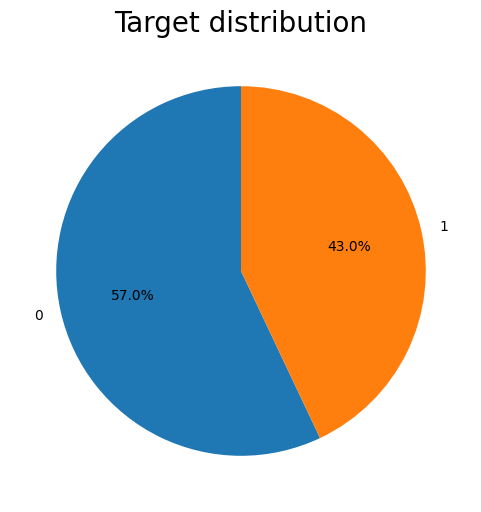

In [8]:
label_counts = df['target'].value_counts()
fig = plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels= label_counts.index, autopct= "%1.1f%%", startangle= 90)
plt.title("Target distribution", size= 20)
plt.show()

In [8]:
for target in df['target'].unique():
    rows = df[df['target'] == target]

    for _, row in rows.iterrows():
        if pd.notna(row['keyword']) and pd.notna(row['location']):
            print(f"Label: {target}\n"
                  f"Text: {row['text']}\n"
                  f"Keyword: {row['keyword']}\n"
                  f"Location: {row['location']}")
            print("-" * 60)
            break


Label: 1
Text: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
Keyword: ablaze
Location: Birmingham
------------------------------------------------------------
Label: 0
Text: We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
Keyword: ablaze
Location: Est. September 2012 - Bristol
------------------------------------------------------------


In [9]:
df[['keyword', 'location']].isna().mean().sort_values(ascending=False)

location    0.332720
keyword     0.008013
dtype: float64

In [10]:
keyword_stats = (
    df.dropna(subset=['keyword'])
      .groupby('keyword')['target']
      .agg(['count', 'mean'])
      .sort_values('mean', ascending=False)
)

keyword_stats.head(10)

,count,mean
keyword,,
derailment,39,1.000000
debris,37,1.000000
wreckage,39,1.000000
outbreak,40,0.975000
typhoon,38,0.973684
oil%20spill,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.931034


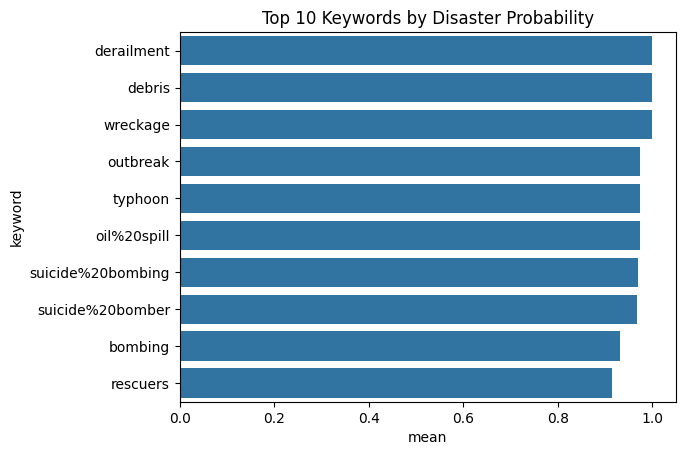

In [11]:
# Example: top 10 keywords by disaster ratio
top_keywords = keyword_stats.sort_values('mean', ascending=False).head(10)
sns.barplot(x='mean', y=top_keywords.index, data=top_keywords)
plt.title('Top 10 Keywords by Disaster Probability')
plt.show()

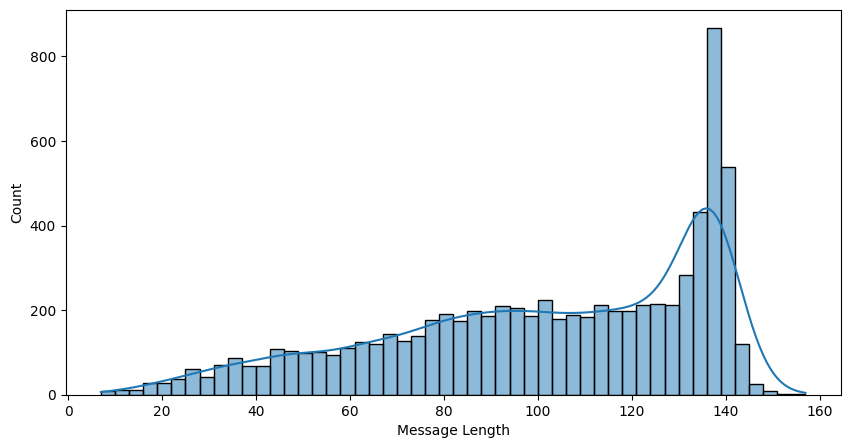

In [12]:
# Add message length column and plot histogram
df['text_length'] = df['text'].apply(len)
plt.figure(figsize= (10, 5))
sns.histplot(df['text_length'], bins= 50, kde= True)
plt.ylabel("Count")
plt.xlabel("Message Length")
plt.show()

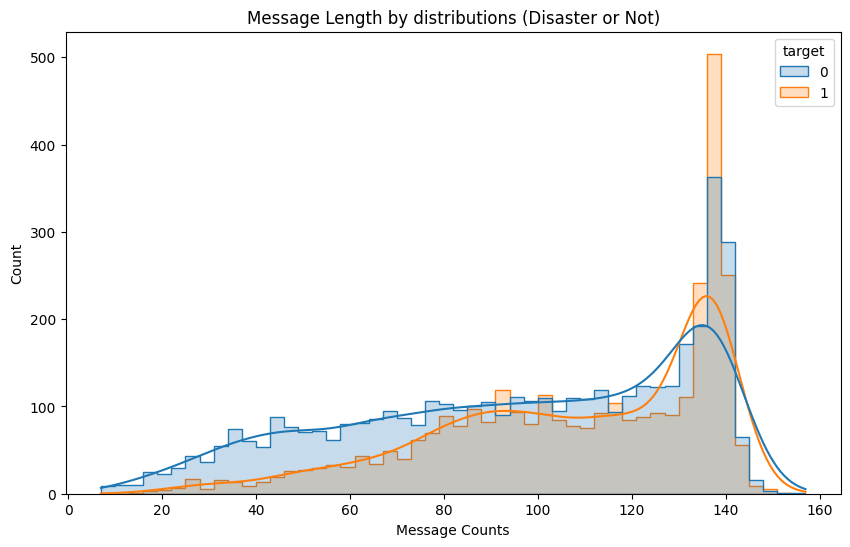

In [13]:
# Histogram of message lengths by label
plt.figure(figsize= (10, 6))
sns.histplot(
    data= df,
    x= 'text_length',
    hue= 'target',
    bins= 50,
    kde= True,
    element= 'step',
    stat= 'count'
)
plt.title("Message Length by distributions (Disaster or Not)")
plt.xlabel("Message Counts")
plt.ylabel("Count")
plt.show()

In [9]:
# 1. safety: drop / fill missing text if any
df['text'] = df['text'].fillna('')

In [10]:
# 2. add character and word counts
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].str.split().apply(len)

In [16]:
# 4.3 Numeric summaries
print("Overall text stats:")
print(df[['char_count','word_count']].describe().T[['count','mean','50%','std','min','max']])
print("\nPer-label mean/median:")
print(df.groupby('target')[['char_count','word_count']].agg(['mean','median','std']).round(2))

Overall text stats:
             count        mean    50%        std  min    max
char_count  7613.0  101.037436  107.0  33.781325  7.0  157.0
word_count  7613.0   14.903586   15.0   5.732604  1.0   31.0

Per-label mean/median:
       char_count               word_count             
             mean median    std       mean median   std
target                                                 
0           95.71  101.0  35.89      14.70   15.0  6.16
1          108.11  115.0  29.31      15.17   15.0  5.10


In [17]:
# 4.4 Show shortest and longest messages per label
for label in df['target'].unique():
    sub = df[df['target']==label].sort_values('char_count')
    print(f"\nLabel = {label}  |  shortest (len={sub.iloc[0]['char_count']}):")
    print(sub.iloc[0]['text'])
    print("-"*60)
    print(f"Label = {label}  |  longest (len={sub.iloc[-1]['char_count']}):")
    print(sub.iloc[-1]['text'][:1000])  # safety cutoff in case extremely long
    print("\n"+ "="*80)


Label = 1  |  shortest (len=14):
Omg earthquake
------------------------------------------------------------
Label = 1  |  longest (len=151):
@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP


Label = 0  |  shortest (len=7):
Err:509
------------------------------------------------------------
Label = 0  |  longest (len=157):
when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????



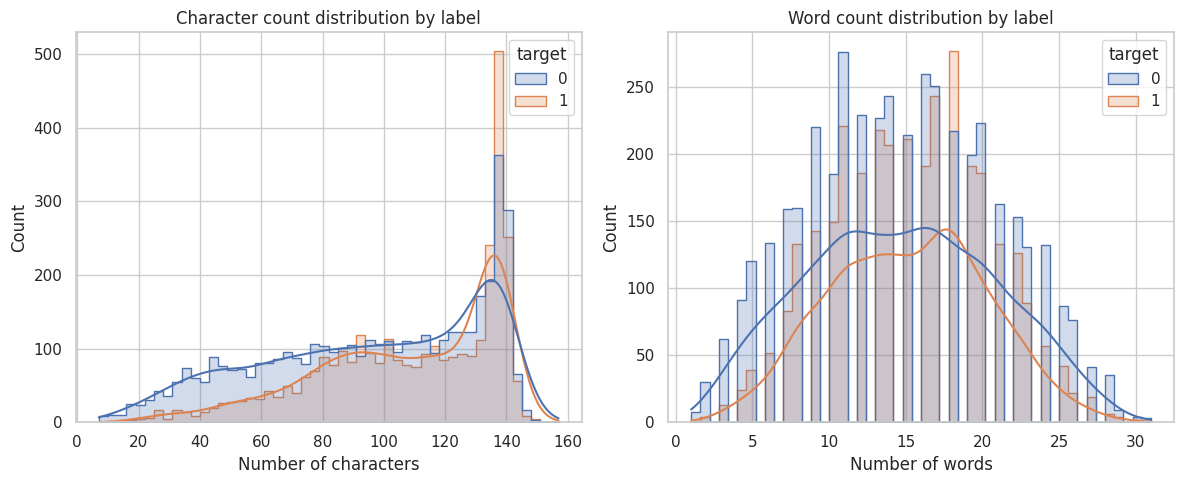

In [18]:
# 4.5 Histogram plots for char_count and word_count by label
sns.set(style="whitegrid")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data=df, x='char_count', hue='target', bins=50, kde=True, element='step', stat='count')
plt.title('Character count distribution by label')
plt.xlabel('Number of characters')

plt.subplot(1,2,2)
sns.histplot(data=df, x='word_count', hue='target', bins=50, kde=True, element='step', stat='count')
plt.title('Word count distribution by label')
plt.xlabel('Number of words')

plt.tight_layout()
plt.show()

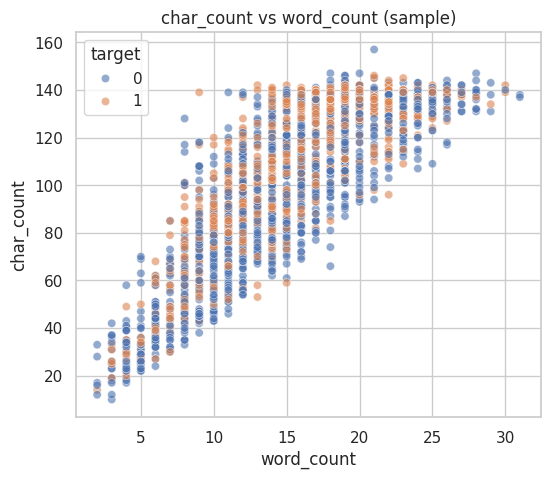

In [19]:
# 4.6 Scatter plot: char_count vs word_count (sample)
plt.figure(figsize=(6,5))
sns.scatterplot(data=df.sample(min(2000, len(df))), x='word_count', y='char_count', hue='target', alpha=0.6)
plt.title('char_count vs word_count (sample)')
plt.show()

In [20]:
# 5.1 Download stopwords and prepare the list
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
disaster_twitts = df[df['target'] == 1]['text']
normal_twitts = df[df['target'] == 0]['text']

In [22]:
def get_words(messages):
    words= []
    for msg in messages:
        for word in msg.lower().split():
            if word.isalpha() and word not in stop_words:
                words.append(word)

    return words

In [23]:
disaster_words = get_words(disaster_twitts)
normal_words = get_words(normal_twitts)

In [24]:
# 5.4 Extract words for ham and spam
disaster_common = Counter(disaster_words).most_common(20)
normal_common = Counter(normal_words).most_common(20)

print(f"Most common Words in Disaster Twitts: {disaster_common}\n")
print(f"Most common Words in Normal Twitts: {normal_common}\n")

Most common Words in Disaster Twitts: [('fire', 151), ('via', 117), ('suicide', 103), ('disaster', 97), ('police', 94), ('people', 93), ('killed', 92), ('like', 91), ('california', 88), ('families', 81), ('two', 71), ('storm', 71), ('train', 71), ('bomb', 67), ('emergency', 66), ('get', 66), ('crash', 65), ('one', 63), ('nuclear', 63), ('bombing', 63)]

Most common Words in Normal Twitts: [('like', 250), ('new', 163), ('get', 161), ('one', 116), ('body', 106), ('via', 97), ('would', 94), ('love', 85), ('got', 82), ('people', 81), ('full', 81), ('see', 79), ('know', 78), ('video', 76), ('back', 75), ('emergency', 75), ('going', 73), ('still', 70), ('time', 69), ('want', 65)]



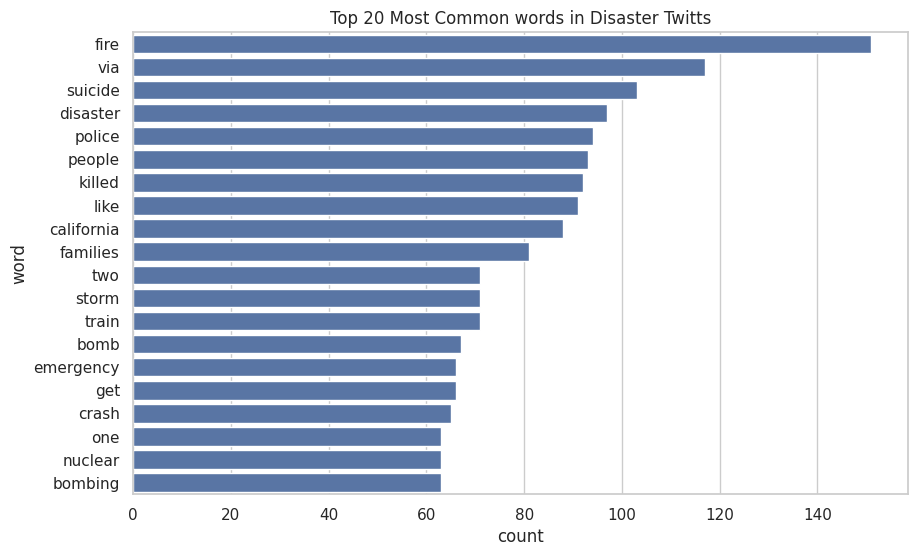

In [25]:
dis_common_df = pd.DataFrame(disaster_common, columns= ['word', 'count'])
plt.figure(figsize= (10, 6))
sns.barplot(x= 'count', y= 'word', data= dis_common_df)
plt.title("Top 20 Most Common words in Disaster Twitts")
plt.show()

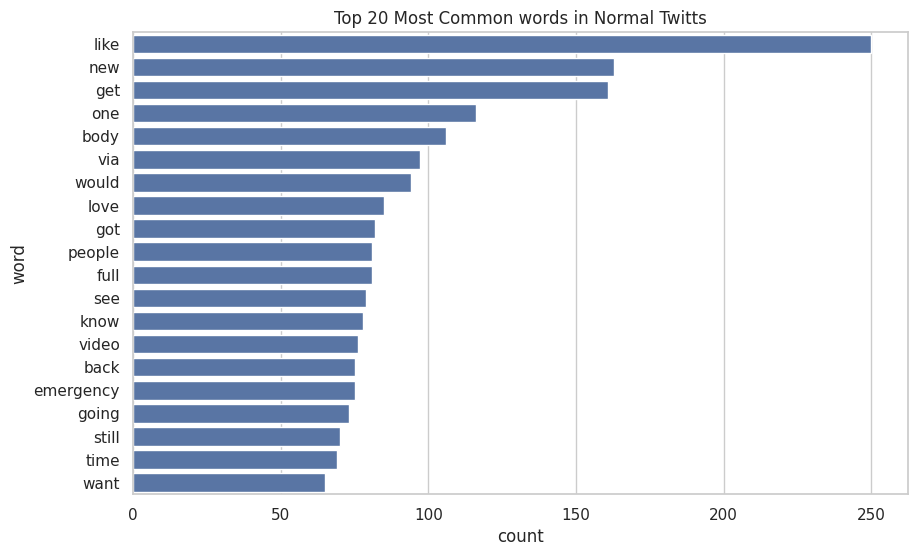

In [26]:
norm_common_df = pd.DataFrame(normal_common, columns= ['word', 'count'])
plt.figure(figsize= (10, 6))
sns.barplot(x= 'count', y= 'word', data= norm_common_df)
plt.title("Top 20 Most Common words in Normal Twitts")
plt.show()

In [27]:
def remove_urls(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

In [28]:
def normalize_text(text):
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    return text

In [29]:
twitter_stopwords = {
    "http", "https", "co", "t", "amp", "via", "rt"
}

all_stopwords = stop_words.union(twitter_stopwords)

In [30]:
disaster_texts = " ".join(
    df[df['target'] == 1]['text']
    .str.lower()
    .apply(remove_urls)
    .apply(normalize_text))

normal_texts = " ".join(
    df[df['target'] == 0]['text']
    .str.lower()
    .apply(remove_urls)
    .apply(normalize_text))

WordCloud is used for qualitative inspection of language patterns and uses a different tokenization strategy than frequency-based counting, which may result in slight differences in visible terms.

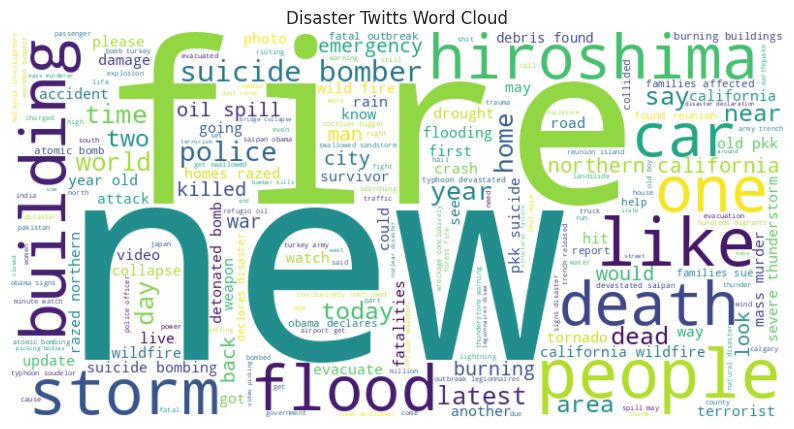

In [31]:
disaster_wc = WordCloud(width= 800, height= 400, background_color= 'white',
                        stopwords= all_stopwords, regexp=r"[a-zA-Z]{3,}",
                        max_words=200).generate(disaster_texts)
plt.figure(figsize= (10, 6))
plt.imshow(disaster_wc, interpolation= 'bilinear')
plt.title("Disaster Twitts Word Cloud")
plt.axis("off")
plt.savefig("disaster-twitts-wordcloud.png", dpi= 300)
plt.show()

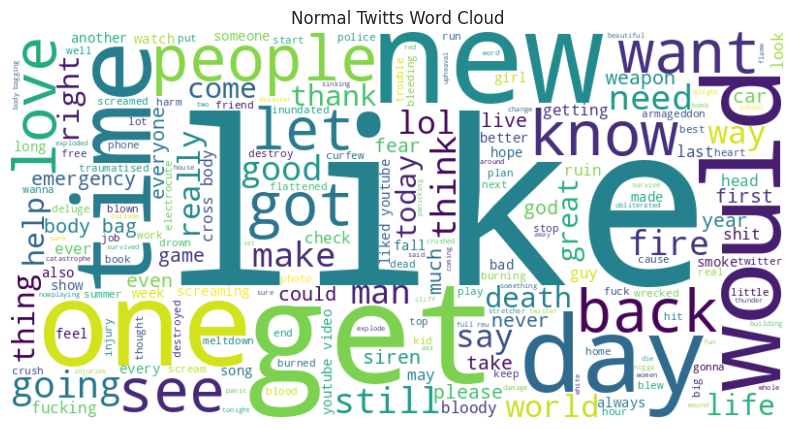

In [33]:
normal_wc = WordCloud(width= 800, height= 400, background_color= 'white',
                        stopwords= all_stopwords, regexp=r"[a-zA-Z]{3,}",
                        max_words=200).generate(normal_texts)
plt.figure(figsize= (10, 6))
plt.imshow(normal_wc, interpolation= 'bilinear')
plt.title("Normal Twitts Word Cloud")
plt.axis("off")
plt.savefig("normal-twitts-wordcloud.png", dpi= 300)
plt.show()

In [34]:
def ngrams(corpus, ngram_range= (2, 2), n= 10):
    vec = CountVectorizer(ngram_range= ngram_range, stop_words= 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis= 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key= lambda x: x[1], reverse= True)

    return words_freq[:n]

In [35]:
# 7.2 Top 10 spam bigrams
top_disaster_bigrams = ngrams(disaster_twitts, ngram_range=(2,2), n=10)
print("Top 10 disaster twitts bigrams:")
for bigram, freq in top_disaster_bigrams:
    print(f"{bigram}: {freq}")


print("\n" +  "-"* 60)

# 7.2 Top 10 ham bigrams
top_normal_bigrams = ngrams(normal_twitts, ngram_range=(2,2), n=10)
print("\nTop 10 Normal twitts bigrams:")
for bigram, freq in top_normal_bigrams:
    print(f"{bigram}: {freq}")

Top 10 disaster twitts bigrams:
û_ http: 109
suicide bomber: 59
northern california: 41
oil spill: 38
burning buildings: 37
suicide bombing: 35
california wildfire: 34
70 years: 30
bomber detonated: 30
confirmed mh370: 29

------------------------------------------------------------

Top 10 Normal twitts bigrams:
û_ http: 108
cross body: 39
youtube video: 36
liked youtube: 35
video http: 27
body bag: 27
gt gt: 26
û_ https: 24
body bagging: 24
burning buildings: 23


In [36]:
# 7.3 Top 10 spam trigrams
top_disaster_trigrams = ngrams(disaster_twitts, ngram_range=(3,3), n=10)
print("Top 10 spam trigrams:")
for trigram, freq in top_disaster_trigrams:
    print(f"{trigram}: {freq}")

print("\n" + "-" * 60)

# 7.3 Top 10 ham trigrams
top_normal_trigrams = ngrams(normal_twitts, ngram_range=(3,3), n=10)
print("\nTop 10 ham trigrams:")
for trigram, freq in top_normal_trigrams:
    print(f"{trigram}: {freq}")

Top 10 spam trigrams:
suicide bomber detonated: 30
northern california wildfire: 29
latest homes razed: 28
homes razed northern: 28
pkk suicide bomber: 28
bomber detonated bomb: 28
razed northern california: 27
16yr old pkk: 27
old pkk suicide: 27
families sue legionnaires: 26

------------------------------------------------------------

Top 10 ham trigrams:
liked youtube video: 35
youtube video http: 19
cross body bag: 19
reddit quarantine offensive: 19
quarantine offensive content: 18
reddit new content: 16
new content policy: 16
stock market crash: 16
read ebay http: 15
ignition knock detonation: 15


In [21]:
def class_specific_ngrams(texts, labels, ngram_range=(2,2), top_n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Convert labels to numpy array to avoid indexing issues
    labels_np = labels.to_numpy()

    X_disaster = X[labels_np==1].toarray().sum(axis=0) + 1  # add-1 smoothing
    X_normal   = X[labels_np==0].toarray().sum(axis=0) + 1

    # Compute log-ratio
    log_ratio = np.log(X_disaster / X_normal)

    # Top n-grams per class
    top_disaster_idx = log_ratio.argsort()[-top_n:][::-1]
    top_normal_idx   = log_ratio.argsort()[:top_n]

    top_disaster = list(zip(feature_names[top_disaster_idx], log_ratio[top_disaster_idx]))
    top_normal   = list(zip(feature_names[top_normal_idx], log_ratio[top_normal_idx]))

    return top_disaster, top_normal

In [22]:
top_disaster, top_normal = class_specific_ngrams(df['text'], df['target'], ngram_range=(2,3), top_n=15)

print("Top Disaster N-grams:")
for ngram, score in top_disaster:
    print(f"{ngram}: {score:.2f}")

print("\nTop Non-Disaster N-grams:")
for ngram, score in top_normal:
    print(f"{ngram}: {score:.2f}")

Top Disaster N-grams:
suicide bomber: 4.09
northern california: 3.74
california wildfire: 3.56
suicide bomber detonated: 3.43
bomber detonated: 3.43
homes razed: 3.40
confirmed mh370: 3.40
northern california wildfire: 3.40
razed northern: 3.37
homes razed northern: 3.37
pkk suicide bomber: 3.37
bomber detonated bomb: 3.37
latest homes razed: 3.37
16yr old: 3.37
latest homes: 3.37

Top Non-Disaster N-grams:
cross body: -3.00
wreck wreck: -2.64
body bag: -2.64
wreck wreck wreck: -2.48
body bags: -2.44
pay pile: -2.40
don let: -2.40
qew4c5m1xd view download: -2.30
view download video: -2.30
http qew4c5m1xd view: -2.30
view download: -2.30
qew4c5m1xd view: -2.30
download video: -2.30
http qew4c5m1xd: -2.30
ebay http: -2.30


In [24]:
def plot_ngrams(ngrams_list, title):
    ngrams, scores = zip(*ngrams_list)
    plt.figure(figsize=(10,5))
    plt.barh(ngrams[::-1], scores[::-1])
    plt.title(title)
    plt.xlabel("Log-Ratio (Disaster vs Non-Disaster)")
    plt.show()

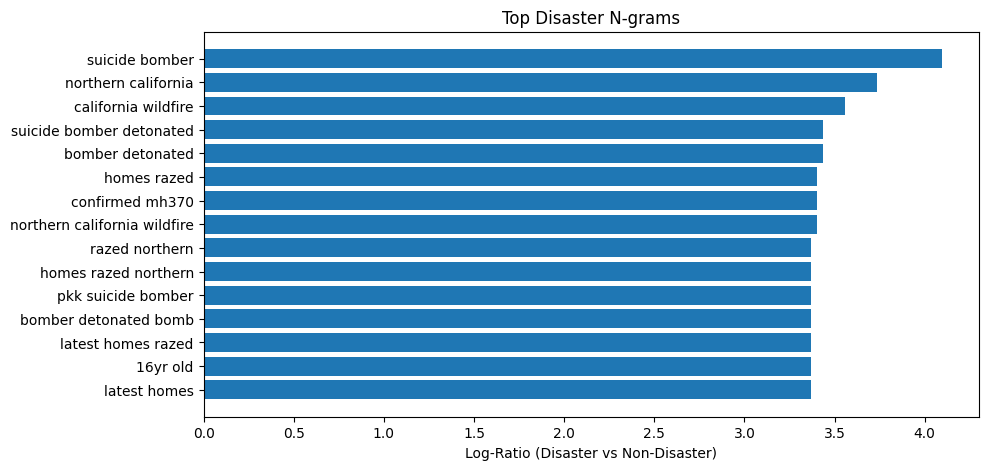

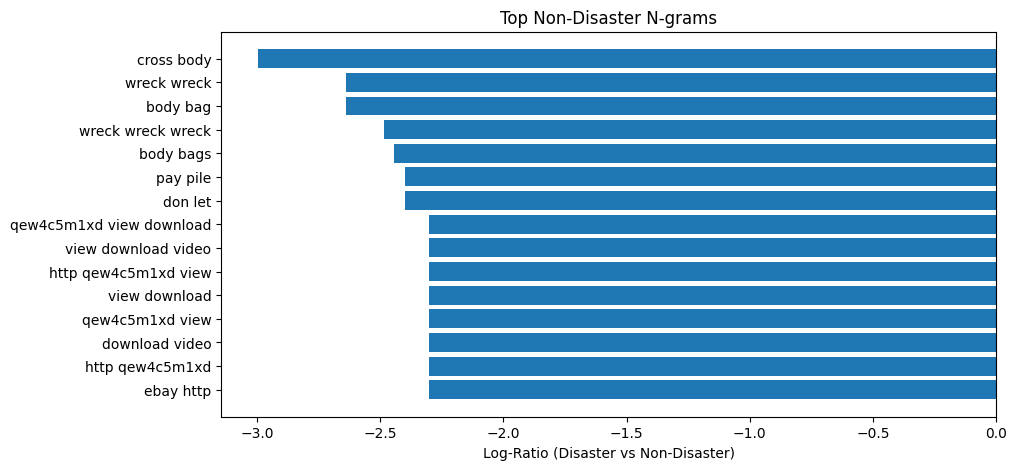

In [25]:
plot_ngrams(top_disaster, "Top Disaster N-grams")
plot_ngrams(top_normal, "Top Non-Disaster N-grams")

In [26]:
# Define short tweet threshold (e.g., <5 words)
short_disaster = df[(df['word_count'] < 5) & (df['target'] == 1)][['text', 'word_count']]
print("Short disaster tweets:")
print(short_disaster.head(10))

Short disaster tweets:
                                                   text  word_count
73                  BigRigRadio Live Accident Awareness           4
94    Suffield Alberta Accident https://t.co/bPTmlF4P10           4
247           annihilating quarterstaff of annihilation           4
300                        Shadow boxing the apocalypse           4
321                  Armageddon https://t.co/uCSUDk3q1d           2
610                          To fight bioterrorism sir.           4
630                          To fight bioterrorism sir.           4
991                           @Yankees body bagging mfs           4
1315                                 My hand is burning           4
1853                             Ina Buted Girl Crush??           4


In [27]:
# Define long tweet threshold (e.g., >25 words)
long_normal = df[(df['word_count'] > 25) & (df['target'] == 0)][['text', 'word_count']]
print("Long non-disaster tweets:")
print(long_normal.head(10))

Long non-disaster tweets:
                                                  text  word_count
49   First night with retainers in. It's quite weir...          27
67   'I can't have kids cuz I got in a bicycle acci...          27
80   mom: 'we didn't get home as fast as we wished'...          27
126  'The only thing that stands between you and yo...          26
128  'Remembering that you are going to die is the ...          27
362  .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: ....          28
465  'Left hand side of a diamond is a graveyard sh...          27
643  Life is amazin same time its crazy niggas dey ...          26
734  Deadpool is already one of my favourite marvel...          28
756  Hw18 going 90-100. Dude was keeping up with me...          26


In [29]:
df['edge_case'] = 0
df.loc[(df['word_count'] < 5) & (df['target'] == 1), 'edge_case'] = 1
df.loc[(df['word_count'] > 25) & (df['target'] == 0), 'edge_case'] = 1

In [13]:
def count_punctuation(text):
    return len(re.findall(r"[^\w\s]", text))

def count_numbers(text):
    return len(re.findall(r"\d", text))

def count_uppercase_words(text):
    return len([w for w in text.split() if w.isupper() and len(w) > 1])

def count_urls(text):
    return len(re.findall(r"http[s]?://\S+|www\.\S+", text))

def count_emojis(text):
    return emoji.emoji_count(text)

def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

def count_mentions(text):
    return len(re.findall(r"@\w+", text))


In [14]:
df['punct_count'] = df['text'].apply(count_punctuation)
df['num_count'] = df['text'].apply(count_numbers)
df['upper_count'] = df['text'].apply(count_uppercase_words)
df['url_count'] = df['text'].apply(count_urls)
df['emoji_count'] = df['text'].apply(count_emojis)
df['hashtag_count'] = df['text'].apply(count_hashtags)
df['mention_count'] = df['text'].apply(count_mentions)
df['exclamation_count'] = df['text'].apply(lambda x: x.count('!'))
df['question_count'] = df['text'].apply(lambda x: x.count('?'))

In [15]:
df['has_num'] = (df['num_count'] > 0).astype(int)
df['has_punct'] = (df['punct_count'] > 0).astype(int)
df['has_exclamation'] = (df['exclamation_count'] > 0).astype(int)
df['has_question'] = (df['question_count'] > 0).astype(int)
df['has_url'] = (df['url_count'] > 0).astype(int)
df['has_emoji'] = (df['emoji_count'] > 0).astype(int)
df['has_hashtag'] = (df['hashtag_count'] > 0).astype(int)
df['has_mention'] = (df['mention_count'] > 0).astype(int)

In [16]:
df['upper_ratio'] = df['upper_count'] / (df['word_count'] + 1)
df['punct_ratio'] = df['punct_count'] / (df['char_count'] + 1)

In [17]:
structural_summary = df.groupby('target')[[
    'has_url',
    'has_hashtag',
    'has_mention',
    'has_emoji',
    'upper_ratio',
    'punct_ratio',
    'num_count',
    'has_exclamation',
    'has_question'
]].mean().round(3)

print(structural_summary)

        has_url  has_hashtag  has_mention  has_emoji  upper_ratio  \
target                                                              
0         0.414        0.204        0.309      0.000        0.048   
1         0.664        0.262        0.204      0.003        0.046   

        punct_ratio  num_count  has_exclamation  has_question  
target                                                         
0             0.065      1.591             0.12         0.173  
1             0.070      2.637             0.06         0.089  


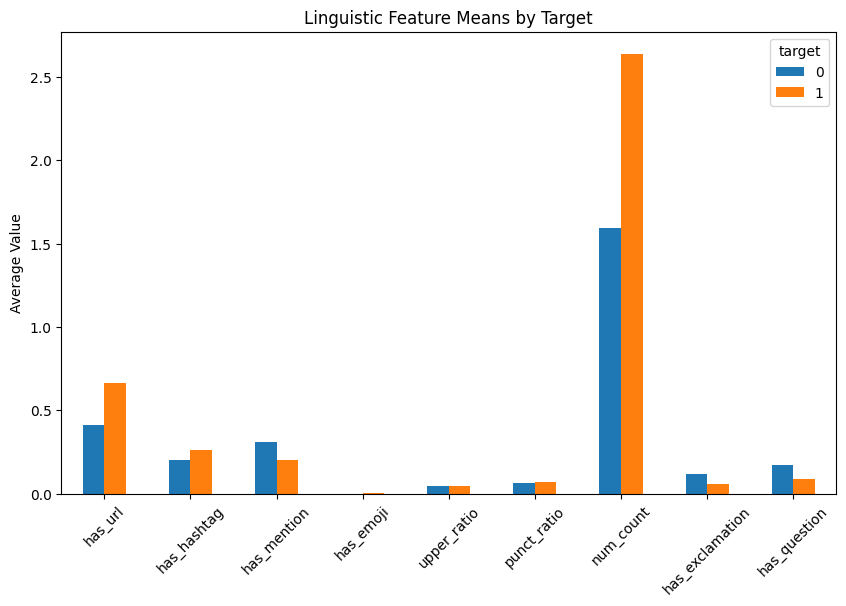

In [18]:
structural_summary.T.plot(kind='bar', figsize=(10,6))
plt.title("Linguistic Feature Means by Target")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.show()

In [43]:
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text.lower())

disaster_hashtags = []
normal_hashtags = []

for _, row in df.iterrows():
    tags = extract_hashtags(row['text'])
    if row['target'] == 1:
        disaster_hashtags.extend(tags)
    else:
        normal_hashtags.extend(tags)

print("Top disaster hashtags:")
print(Counter(disaster_hashtags).most_common(15))

print("\nTop normal hashtags:")
print(Counter(normal_hashtags).most_common(15))


Top disaster hashtags:
[('news', 56), ('hiroshima', 22), ('earthquake', 19), ('hot', 13), ('prebreak', 13), ('best', 13), ('japan', 11), ('india', 10), ('yyc', 10), ('breaking', 9), ('worldnews', 9), ('world', 9), ('isis', 9), ('sismo', 9), ('abstorm', 9)]

Top normal hashtags:
[('nowplaying', 21), ('news', 20), ('hot', 18), ('prebreak', 17), ('best', 17), ('gbbo', 14), ('jobs', 14), ('islam', 14), ('job', 12), ('hiring', 10), ('fashion', 9), ('edm', 8), ('dnb', 8), ('beyhive', 8), ('directioners', 8)]


In [44]:
hashtag_df = (
    df[df['has_hashtag'] == 1]
    .assign(hashtags=lambda x: x['text'].apply(extract_hashtags))
    .explode('hashtags')
    .dropna(subset=['hashtags'])
)

hashtag_stats = (
    hashtag_df.groupby('hashtags')['target']
    .agg(['count', 'mean'])
    .sort_values('mean', ascending=False)
)

hashtag_stats.head(10)

,count,mean
hashtags,,
16,1,1.0
yycweather,1,1.0
yyj,1,1.0
yzf,1,1.0
zaatari,1,1.0
zionism,2,1.0
zionist,4,1.0
worldvision,1,1.0
worldwatchesferguson,1,1.0


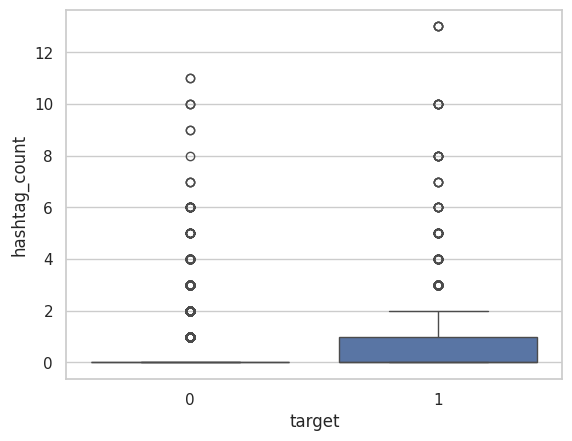

In [45]:
# 8.4 Boxplot for numeric counts by label
sns.boxplot(data=df, x="target", y="hashtag_count")
plt.show()

In [46]:
# 9.7 Unique words in spam messages
disaster_words = Counter(" ".join(df[df['target']== 1]['text']).split())
normal_words  = Counter(" ".join(df[df['target']== 0]['text']).split())

unique_disaster_words = set(disaster_words) - set(normal_words)
print(len(unique_disaster_words))
print(list(unique_disaster_words)[:30])

11364
['#Biztip', '#OK.', 'Ghost', 'http://t.co/2872J5d4HB', 'http://t.co/PHNEZ60cwe', '2.2', 'DT', 'boat.#News', 'http://t.co/kF0QYBKZOL', 'sandunes', 'thunderstorm..', 'http://t.co/Z2Ph0ArzYI', 'In...', 'work??', 'at\x89Û_', 'studies:', 'Dubbo', '@cspan', 'cuts', 'CALABRIA', 'farmland', 'Millions', '210', '@LondonFire', 'Walker:', 'punishing', 'rages:', 'http://t.co/BMxsndx14g', 'GUAbxFv', 'bartender']


In [47]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [48]:
def vader_scores(text):
    scores = sia.polarity_scores(text)
    return pd.Series(scores)

sentiment_df = df['text'].apply(vader_scores)

df = pd.concat([df, sentiment_df], axis=1)

In [49]:
sentiment_summary = (
    df.groupby('target')[['neg', 'neu', 'pos', 'compound']]
    .mean()
    .round(3)
)

print(sentiment_summary)

          neg    neu    pos  compound
target                               
0       0.132  0.766  0.102    -0.061
1       0.174  0.777  0.049    -0.265


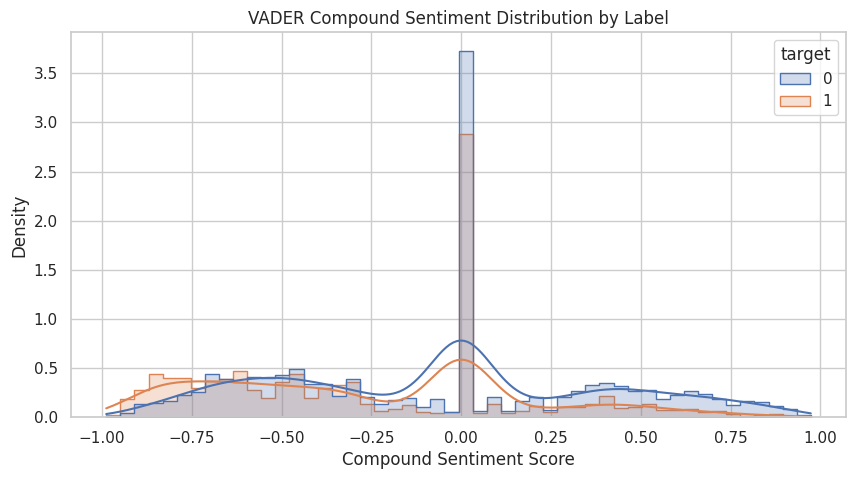

In [50]:
plt.figure(figsize=(10,5))
sns.histplot(
    data=df,
    x='compound',
    hue='target',
    bins=50,
    kde=True,
    element='step',
    stat='density'
)
plt.title("VADER Compound Sentiment Distribution by Label")
plt.xlabel("Compound Sentiment Score")
plt.show()

In [51]:
df[(df['compound'] < -0.5) & (df['target'] == 0)][['text', 'compound']].head(5)

,text,compound
34,Crying out for more! Set me ablaze,-0.5255
36,@PhDSquares #mufc they've built so much hype a...,-0.5023
41,on the outside you're ablaze and alive\nbut yo...,-0.7311
71,#stlouis #caraccidentlawyer Speeding Among Top...,-0.5574
75,RT @SleepJunkies: Sleeping pills double your r...,-0.6369


In [52]:
df[(df['compound'] > 0.2) & (df['target'] == 1)][['text', 'compound']].head(5)

,text,compound
0,Our Deeds are the Reason of this #earthquake M...,0.2732
11,Haha South Tampa is getting flooded hah- WAIT ...,0.4588
224,@violentfeminazi I guess that's ok for Armenia...,0.2960
225,70 years since we annihilated 100000 people in...,0.3182
229,Ready to get annihilated for the BUCS game,0.3612


Sentiment analysis reveals that disaster tweets are on average more negative than non-disaster tweets. However, there is significant overlap between the two classes. Many non-disaster tweets express strong negative emotions unrelated to real disasters, while some disaster tweets are neutral or informational in tone. This confirms that sentiment alone is insufficient for classification but provides useful complementary signal when combined with structural and lexical features.

In [53]:
danger_lexicons = {
    "death": [
        "death", "dead", "killed", "fatal", "dying", "casualties"
    ],
    "injury": [
        "injured", "wounded", "hurt", "bleeding"
    ],
    "emergency": [
        "emergency", "evacuate", "evacuation", "rescue", "alert"
    ],
    "violence": [
        "attack", "shooting", "bomb", "explosion", "terror"
    ],
    "natural_disaster": [
        "earthquake", "flood", "fire", "wildfire", "hurricane",
        "storm", "tornado", "tsunami", "volcano"
    ]
}

In [54]:
def count_lexicon_hits(text, lexicon):
    text = text.lower()
    return sum(word in text for word in lexicon)

for category, words in danger_lexicons.items():
    df[f'{category}_count'] = df['text'].apply(
        lambda x: count_lexicon_hits(x, words)
    )

In [55]:
for category in danger_lexicons.keys():
    df[f'has_{category}'] = (df[f'{category}_count'] > 0).astype(int)

In [56]:
danger_summary = (
    df.groupby('target')[[f'has_{c}' for c in danger_lexicons.keys()]]
    .mean()
    .round(3)
)

print(danger_summary)

        has_death  has_injury  has_emergency  has_violence  \
target                                                       
0           0.036       0.015          0.033         0.039   
1           0.102       0.024          0.077         0.136   

        has_natural_disaster  
target                        
0                      0.078  
1                      0.238  


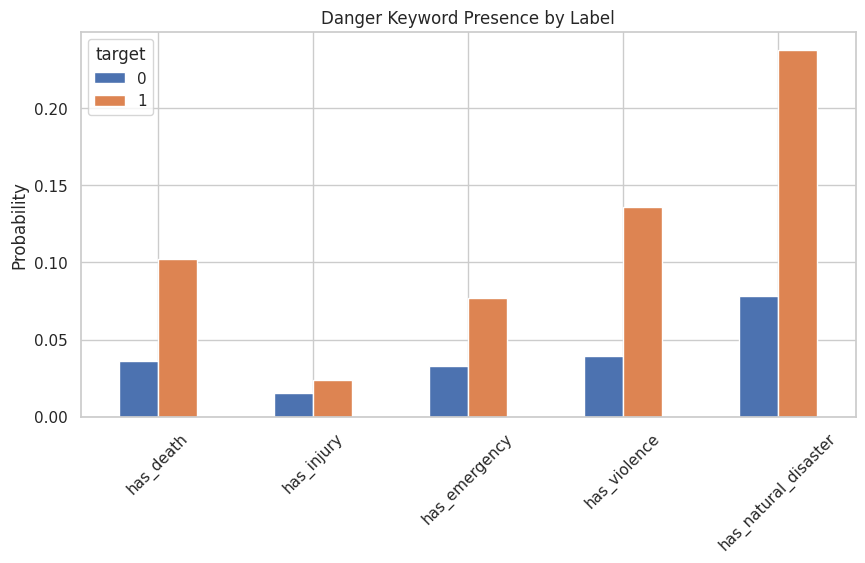

In [57]:
danger_summary.T.plot(kind='bar', figsize=(10,5))
plt.title("Danger Keyword Presence by Label")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.show()

In [58]:
df[(df['has_death'] == 1) & (df['target'] == 0)][['text']].head(5)

,text
41,on the outside you're ablaze and alive\nbut yo...
138,@crobscarla your lifetime odds of dying from a...
150,@mickinyman @TheAtlantic That or they might be...
167,Statistically I'm at more of risk of getting k...
245,Evildead - Annihilation of Civilization http:/...


In [59]:
df[
    (df[[f'has_{c}' for c in danger_lexicons.keys()]].sum(axis=1) == 0)
    & (df['target'] == 1)
][['text']].head(5)

,text
10,Three people died from the heat wave so far
14,Damage to school bus on 80 in multi car crash ...
31,@bbcmtd Wholesale Markets ablaze http://t.co/l...
33,#AFRICANBAZE: Breaking news:Nigeria flag set a...
37,INEC Office in Abia Set Ablaze - http://t.co/3...


Explicit danger and emergency-related keywords strongly correlate with disaster tweets, particularly terms related to natural disasters, fatalities, and emergency response. However, a subset of non-disaster tweets also contains violent or dramatic language unrelated to real events, while some disaster tweets remain neutral or implicit. These findings suggest that lexicon-based features provide strong but incomplete signal and should be combined with contextual and learned representations.

In [63]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [64]:
def pos_ratios(text):
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    
    num_tokens = len(tokens)
    if num_tokens == 0:
        return 0, 0  # avoid division by zero
    
    num_nouns = sum(1 for w, t in tags if t.startswith('NN'))  # NN, NNS, NNP, NNPS
    num_verbs = sum(1 for w, t in tags if t.startswith('VB'))  # VB, VBD, VBG, VBN, VBP, VBZ
    
    return num_nouns / num_tokens, num_verbs / num_tokens

In [65]:
# Apply to dataset
df[['noun_ratio', 'verb_ratio']] = df['text'].apply(lambda x: pd.Series(pos_ratios(x)))

In [66]:
pos_summary = df.groupby('target')[['noun_ratio', 'verb_ratio']].mean().round(3)
print(pos_summary)

        noun_ratio  verb_ratio
target                        
0            0.384       0.129
1            0.449       0.104


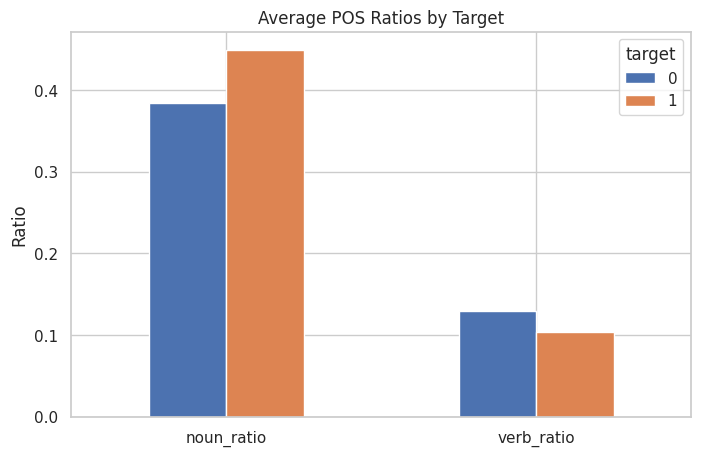

In [67]:
pos_summary.T.plot(kind='bar', figsize=(8,5))
plt.title("Average POS Ratios by Target")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.show()